In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [15]:

def compute_box_3d(dim, location, rotation_y):
    # dim: 3
    # location: 3
    # rotation_y: 1
    # return: 8 x 3
    c, s = np.cos(rotation_y), np.sin(rotation_y)
    R = np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]], dtype=np.float32)
    l, w, h = dim[2], dim[1], dim[0]
    x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
    y_corners = [0,0,0,0,-h,-h,-h,-h]
    z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]

    corners = np.array([x_corners, y_corners, z_corners], dtype=np.float32)
    corners_3d = np.dot(R, corners) 
    corners_3d = corners_3d + np.array(location, dtype=np.float32).reshape(3, 1)
    return corners_3d.transpose(1, 0)

def project_to_image(pts_3d, P):
  # pts_3d: n x 3
    # P: 3 x 4
    # return: n x 2
    pts_3d_homo = np.concatenate(
        [pts_3d, np.ones((pts_3d.shape[0], 1), dtype=np.float32)], 
        axis=1
    )
    pts_2d = np.dot(P, pts_3d_homo.transpose(1, 0)).transpose(1, 0)
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:]
    # import pdb; pdb.set_trace()
    return pts_2d

def draw_box_3d(image, corners, c=(0, 0, 255)):
    face_idx = [[0,1,5,4],
              [1,2,6, 5],
              [2,3,7,6],
              [3,0,4,7]]
    for ind_f in range(3, -1, -1):
        f = face_idx[ind_f]
        for j in range(4):
            cv2.line(
            image, 
            (int(corners[f[j], 0]), int(corners[f[j], 1])),
            (int(corners[f[(j+1)%4], 0]), int(corners[f[(j+1)%4], 1])), 
            c, 2, lineType=cv2.LINE_AA
            )
        if ind_f == 0:
            cv2.line(image, (int(corners[f[0], 0]), int(corners[f[0], 1])),
                   (int(corners[f[2], 0]), int(corners[f[2], 1])), c, 1, lineType=cv2.LINE_AA)
            cv2.line(image, (int(corners[f[1], 0]), int(corners[f[1], 1])),
                   (int(corners[f[3], 0]), int(corners[f[3], 1])), c, 1, lineType=cv2.LINE_AA)
            
    return image

def read_clib(calib_path):
    f = open(calib_path, 'r')
    for i, line in enumerate(f):
        if i == 2:
            calib = np.array(line[:-1].split(' ')[1:], dtype=np.float32)
            calib = calib.reshape(3, 4)
            return calib

[1.63, 1.48, 2.37]
[3.23, 0.0, 8.55]
-1.47

[1.41, 1.58, 4.36]
[3.18, 0.0, 34.38]
-1.58



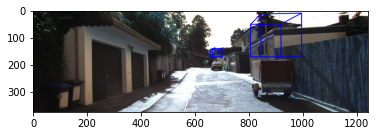

In [17]:

img_id = '000002'

ann_path = f'/home/ubuntu/data/kitti/training/label_2/{img_id}.txt'
anns = open(ann_path, 'r')

calib_path = f'/home/ubuntu/data/kitti/training/calib/{img_id}.txt'
calib = read_clib(calib_path)

img_path = f'/home/ubuntu/data/kitti/training/image_2/{img_id}.png'
image = cv2.imread(img_path)

for ann_ind, txt in enumerate(anns):
    tmp = txt[:-1].split(' ')
    truncated = int(float(tmp[1]))
    occluded = int(tmp[2])
    alpha = float(tmp[3])
    bbox = [float(tmp[4]), float(tmp[5]), float(tmp[6]), float(tmp[7])]
    dim = [float(tmp[8]), float(tmp[9]), float(tmp[10])]
    location = [float(tmp[11]), float(tmp[12]), float(tmp[13])]
    rotation_y = float(tmp[14])
    
    location[1] = 0.
    
    print(dim)
    print(location)
    print(rotation_y)
    print()

    box_3d = compute_box_3d(dim, location, rotation_y)
    box_2d = project_to_image(box_3d, calib)
    image = draw_box_3d(image, box_2d)
    
    plt.imshow(image)
